In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pathlib

In [42]:
input_ = tf.keras.layers.Input(shape=(224, 224, 1), name="INPUT")
normalization = tf.keras.layers.Rescaling(1./255)(input_) # Standardize the data
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=1, activation="relu", padding="same", name="CONV1")(normalization) 
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL1")(conv1) 
conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=1, activation="relu", padding="same", name="CONV2")(pool1)
concat1 = tf.keras.layers.Concatenate()([pool1, conv2])

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL2")(concat1)
conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=1, activation="relu", padding="same", name="CONV3")(pool2)
concat2 = tf.keras.layers.Concatenate()([pool2, conv3])

pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL3")(concat2)
conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=1, activation="relu", padding="same", name="CONV4")(pool3)
concat3 = tf.keras.layers.Concatenate()([pool3, conv4])

pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL4")(concat3)
flatten = tf.keras.layers.Flatten()(pool4)
fc1 = tf.keras.layers.Dense(4096, activation='relu')(flatten)
dropout1 = tf.keras.layers.Dropout(0.5)(fc1)
fc2 = tf.keras.layers.Dense(2048, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(fc2)

output = tf.keras.layers.Dense(7, activation='softmax')(dropout2)

model = tf.keras.Model(
    inputs=[input_],
    outputs=[output]
)

Load in / prep the data

In [18]:
train_dir = pathlib.Path("Train v2").with_suffix('')
test_dir = pathlib.Path("Test v2").with_suffix('')

In [19]:
print(f"Number of images for training/val: {len(list(train_dir.glob('*/*.jpg')))}")
print(f"NUmber of images for testing: {len(list(test_dir.glob('*/*.jpg')))}") 

Number of images for training/val: 3842
NUmber of images for testing: 180


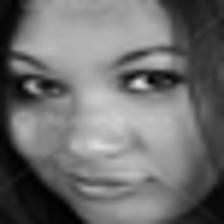

In [25]:
# Display an image
angry = list(test_dir.glob('Neutral/*'))
Image.open(str(angry[0]))

In [14]:
# Check how many samples fall into each emotion category
print("Number of samples in each emotion category in the Train/Val set")
for e in ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]:
    print(f"Emotion:{e}, # Samples:{len(list(train_dir.glob(f'{e}/*')))}")

Number of samples in each emotion category in the Train/Val set
Emotion:Angry, # Samples:517
Emotion:Disgust, # Samples:333
Emotion:Fear, # Samples:512
Emotion:Happy, # Samples:583
Emotion:Neutral, # Samples:570
Emotion:Sad, # Samples:678
Emotion:Surprise, # Samples:649


In [26]:
# Convert images to format compatible with TF

im_size = (224, 224)
val_split = 0.1
batch_size = 32
seed = 11
mode = "grayscale"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=(im_size),
    batch_size=batch_size,
    color_mode=mode
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=(im_size),
    batch_size=batch_size,
    color_mode=mode
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=im_size,
    batch_size=batch_size,
    color_mode=mode
)

Found 3842 files belonging to 7 classes.
Using 3458 files for training.
Found 3842 files belonging to 7 classes.
Using 384 files for validation.
Found 210 files belonging to 7 classes.


In [43]:
model.compile( 
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=(val_ds)
)

Epoch 1/15


109/109 [==============================] - 391s 4s/step - loss: 2.0562 - accuracy: 0.1802 - val_loss: 1.8927 - val_accuracy: 0.2370
Epoch 2/15
109/109 [==============================] - 387s 4s/step - loss: 1.8371 - accuracy: 0.2606 - val_loss: 1.7741 - val_accuracy: 0.3203
Epoch 3/15
109/109 [==============================] - 386s 4s/step - loss: 1.7688 - accuracy: 0.3010 - val_loss: 1.6808 - val_accuracy: 0.3698
Epoch 4/15
109/109 [==============================] - 392s 4s/step - loss: 1.6475 - accuracy: 0.3462 - val_loss: 1.6536 - val_accuracy: 0.3620
Epoch 5/15
109/109 [==============================] - 400s 4s/step - loss: 1.4943 - accuracy: 0.4268 - val_loss: 1.6089 - val_accuracy: 0.3854
Epoch 6/15
109/109 [==============================] - 392s 4s/step - loss: 1.3488 - accuracy: 0.4986 - val_loss: 1.5967 - val_accuracy: 0.3958
Epoch 7/15
109/109 [==============================] - 398s 4s/step - loss: 1.1711 - accuracy: 0.5630 - val_loss: 1.8213 - val_accuracy: 0.3776
Epoch 8/15

Make Predictions

In [45]:
predicted = []
actual = []

for images, labels in val_ds:
    probabilities = model.predict(images)

    for pred in probabilities:
        predicted.append(np.argmax(pred))
    
    for l in labels:
        actual.append(l)

1/1 [==============================] - 1s 929ms/step


In [ ]:
expressions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

for i in range(len(actual)):
    print(f"Actual={expressions[actual[i].numpy()]}, Predicted={expressions[predicted[i]]}")

Confusion Matrix

In [19]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [46]:
array = tf.math.confusion_matrix(labels=actual, predictions=predicted)

[Text(0.5, 47.7222222222222, 'Predicted'),
 Text(95.72222222222221, 0.5, 'Actual')]

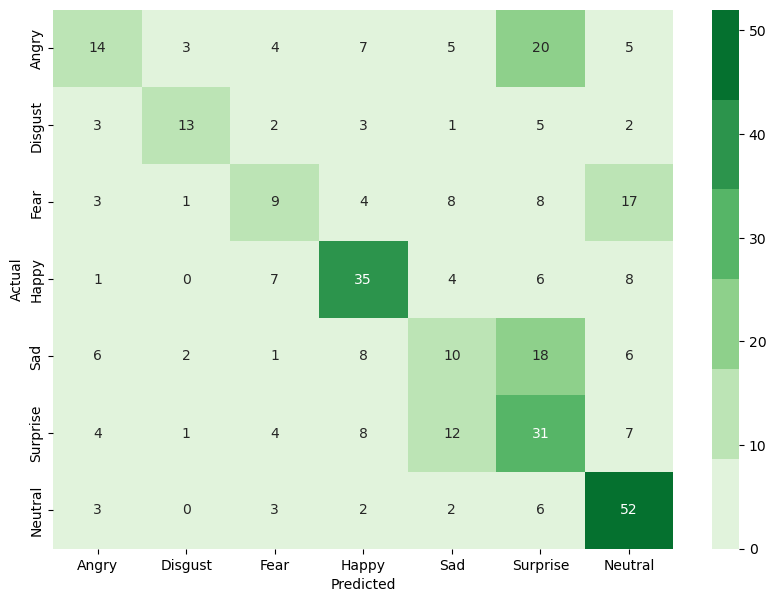

In [47]:
plt.figure(figsize=(10,7))
l = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
sns.heatmap(array, annot=True, cmap=sns.color_palette("Greens"), xticklabels=l, yticklabels=l).set(xlabel="Predicted", ylabel="Actual")

Model Metrics

In [13]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [48]:
print(f"F1-Score:   {dict( zip( l, f1_score(actual, predicted, average=None) ) )}")
print(f"Accuracy:   {accuracy_score(actual, predicted)}")
print(f"Precision:  {dict( zip( l, precision_score(actual, predicted, average=None) ) )}")
print(f"Recall:     {dict( zip( l, recall_score(actual, predicted, average=None) ) )}")

F1-Score:   {'Angry': 0.30434782608695654, 'Disgust': 0.5306122448979592, 'Fear': 0.225, 'Happy': 0.546875, 'Sad': 0.21505376344086022, 'Surprise': 0.38509316770186336, 'Neutral': 0.6303030303030303}
Accuracy:   0.4270833333333333
Precision:  {'Angry': 0.4117647058823529, 'Disgust': 0.65, 'Fear': 0.3, 'Happy': 0.5223880597014925, 'Sad': 0.23809523809523808, 'Surprise': 0.32978723404255317, 'Neutral': 0.5360824742268041}
Recall:     {'Angry': 0.2413793103448276, 'Disgust': 0.4482758620689655, 'Fear': 0.18, 'Happy': 0.5737704918032787, 'Sad': 0.19607843137254902, 'Surprise': 0.4626865671641791, 'Neutral': 0.7647058823529411}


Save the model

In [49]:
model.save('v2.keras')

Load a model

In [2]:
m = tf.keras.models.load_model('v2.keras')

In [27]:
predicted = []
actual = []

for images, labels in test_ds:
    probabilities = m.predict(images)

    for pred in probabilities:
        predicted.append(np.argmax(pred))
    
    for l in labels:
        actual.append(l)

1/1 [==============================] - 0s 332ms/step


In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [28]:
array = tf.math.confusion_matrix(labels=actual, predictions=predicted)

[Text(0.5, 47.7222222222222, 'Predicted'),
 Text(95.72222222222221, 0.5, 'Actual')]

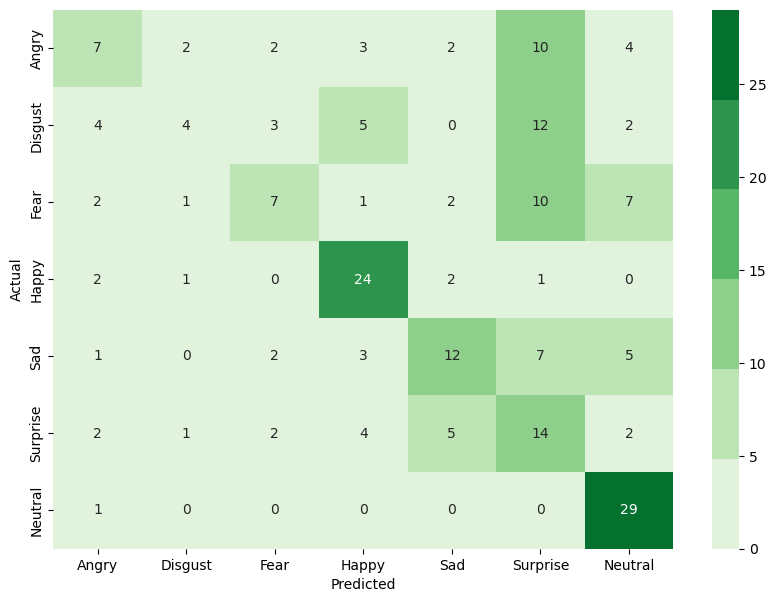

In [29]:
plt.figure(figsize=(10,7))
l = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
sns.heatmap(array, annot=True, cmap=sns.color_palette("Greens"), xticklabels=l, yticklabels=l).set(xlabel="Predicted", ylabel="Actual")

In [30]:
print(f"F1-Score:   {dict( zip( l, f1_score(actual, predicted, average=None) ) )}")
print(f"Accuracy:   {accuracy_score(actual, predicted)}")
print(f"Precision:  {dict( zip( l, precision_score(actual, predicted, average=None) ) )}")
print(f"Recall:     {dict( zip( l, recall_score(actual, predicted, average=None) ) )}")

F1-Score:   {'Angry': 0.2857142857142857, 'Disgust': 0.20512820512820512, 'Fear': 0.30434782608695654, 'Happy': 0.6857142857142857, 'Sad': 0.4528301886792453, 'Surprise': 0.3333333333333333, 'Neutral': 0.7341772151898734}
Accuracy:   0.46190476190476193
Precision:  {'Angry': 0.3684210526315789, 'Disgust': 0.4444444444444444, 'Fear': 0.4375, 'Happy': 0.6, 'Sad': 0.5217391304347826, 'Surprise': 0.25925925925925924, 'Neutral': 0.5918367346938775}
Recall:     {'Angry': 0.23333333333333334, 'Disgust': 0.13333333333333333, 'Fear': 0.23333333333333334, 'Happy': 0.8, 'Sad': 0.4, 'Surprise': 0.4666666666666667, 'Neutral': 0.9666666666666667}
